In [1]:
# Imports
from PrettyShortML import PrettyShortML as psml
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
# Load in sample data: breast cancer classification (binary classes)
random_state = 42
X, y = datasets.load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X[:, :10])  # to speed up, we just take the first 10 features
y = pd.DataFrame(y)
# Also, Sklearn does not like int columns
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)
X, y

(         0      1       2       3        4        5        6        7       8  \
 0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
 1    20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690  0.07017  0.1812   
 2    19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740  0.12790  0.2069   
 3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
 4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
 ..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
 564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
 565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
 566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
 567  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140  0.15200  0.2397   
 568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587   
 
            9 

Inspect dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    float64
 1   1       569 non-null    float64
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
dtypes: float64(10)
memory usage: 44.6 KB
None


Inspect descriptive statistics:
                0           1           2            3           4  \
count  569.000000  569.000000  569.000000   569.000000  569.000000   
mean    14.127292   19.289649   91.969033   654.889104    0.096360   
std      3.524049    4.301036   24.298981   351.914129    0.014064   
min      6.981000    9.710000   43.790000   143.500000    0.052630   
25% 

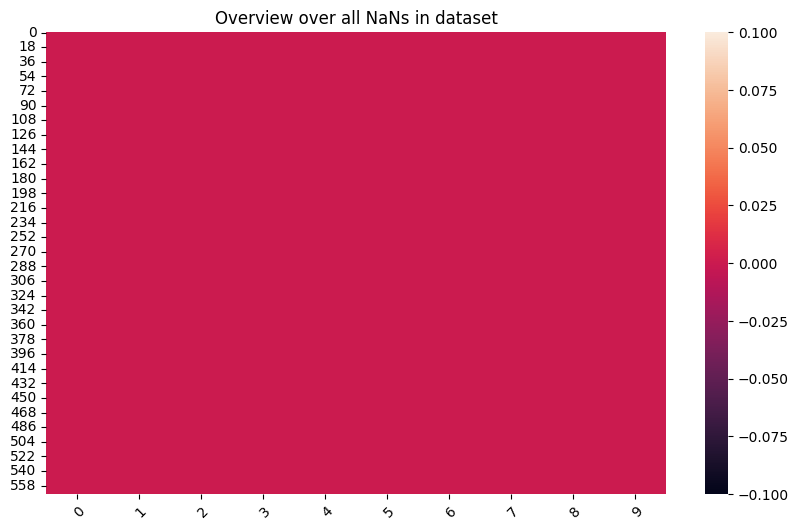

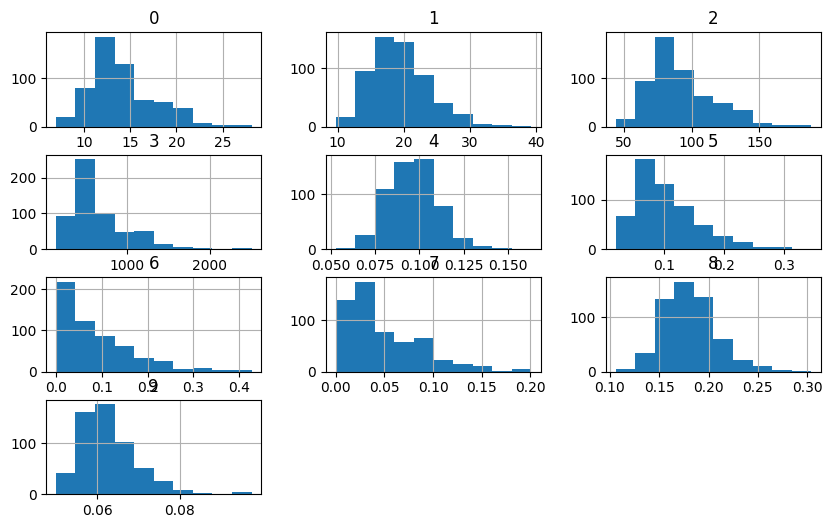

In [3]:
# Do basic EDA
psml.eda_clean_check(X)

In [4]:
# This data is workable, so let's load a class instance after doing a train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)
my_dataset = psml(
    X_train=data_train,
    X_test=data_test,
    y_train=labels_train,
    y_test=labels_test,
)

Starting to plot pairplots. Depending on the dateset size, this may take a while... 
Should it take too long, consider changing the default 'kind' parameter to something else than 'reg'.


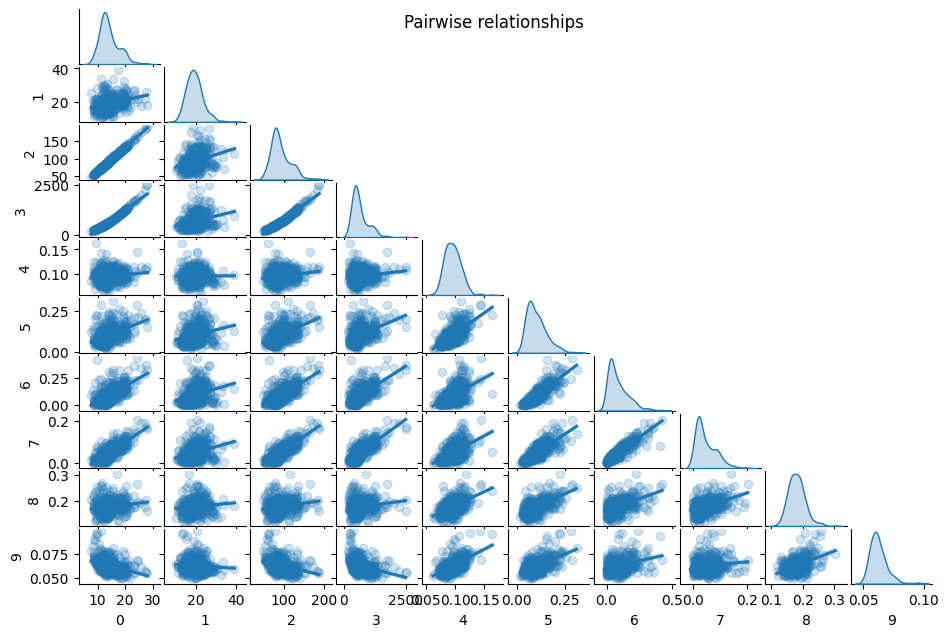

In [5]:
# Plot feature pair plots to inspect distributions and linear relationships
_plotting_ax = psml.plot_eda_pairplot(
    data=my_dataset.X_train, corner=True, dropna=False, plot_hist=False, fig_size=(9, 6)
)

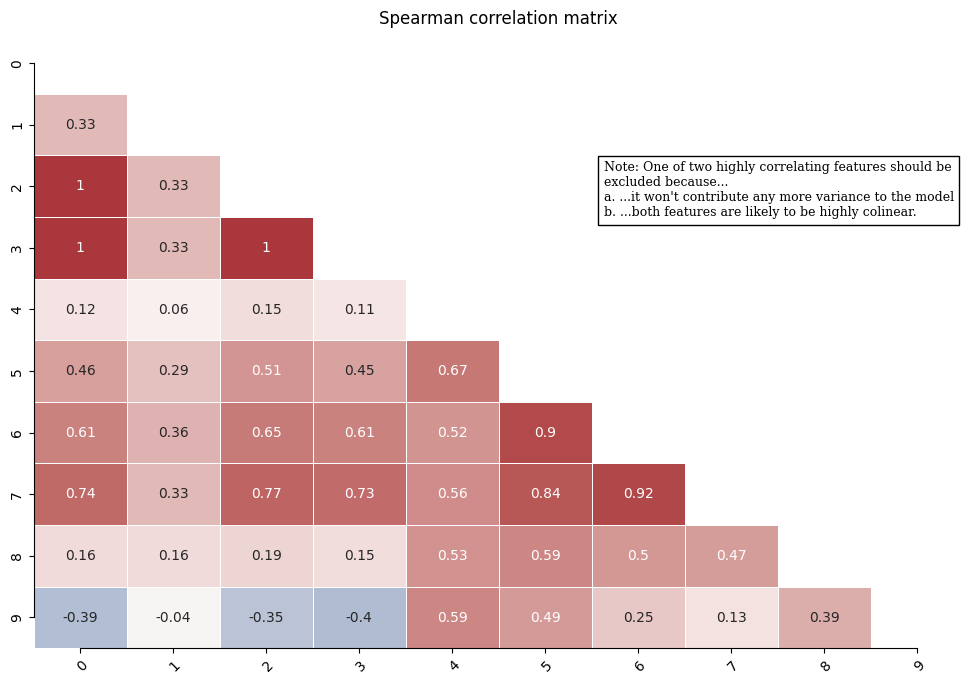

In [6]:
# Plot feature correlation matrix to spot colinearity
_plotting_ax = psml.plot_eda_corr_mat(
    data=my_dataset.X_train, metric="spearman", cmap="vlag", mask=True, annot=True
)


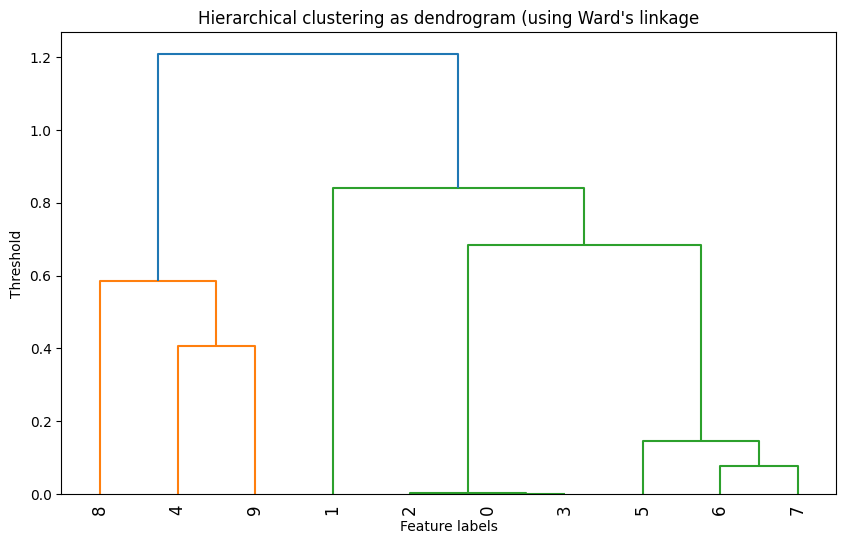

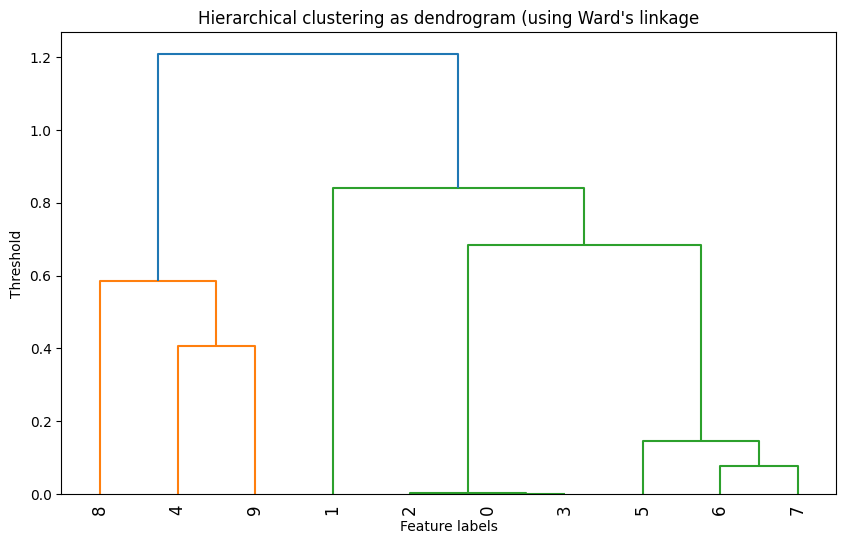

In [7]:
# Normally, we'd do a decent amount of feature cleaning and engineering here.
# For now, let's just do hierarchical clustering on the features' rank-order correlations
# to select features.
_plotting_ax, dist_linkage = psml.plot_hierarchical_clustering(data=my_dataset.X_train)
selected_features = psml.cluster_informed_feature_selection(
    data=my_dataset.X_train, cluster_threshold=0.5
)
# Select the features
my_dataset.X_train = my_dataset.X_train.iloc[:, selected_features]
my_dataset.X_test = my_dataset.X_test.iloc[:, selected_features]

In [12]:
# let's train the model now using a CV splitter and some
# params to do gridsearch. Model_train runs SimpleImputer and StandardScaler on default
# for numerical features. We can use the instance instead of passing the data explicitly.
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=random_state)
param_grid = {
    "estimator__solver": ("lbfgs", "liblinear", "newton-cg"),
    "estimator__fit_intercept": (True, False),
}
pipeline, training_score = my_dataset.model_train(
    LogisticRegression(),
    numeric_features=my_dataset.X_train.columns,
    param_grid=param_grid,
    cv=cv_splitter,
)
print(f"The model's performance on training data:\n{training_score:.4f}")

Building and fitting LogisticRegression estimator...
set_config() got an unexpected keyword argument 'transform_output' Couldn't set sklearn's set_config. Is your sklearn version 1.2+ ?
model_train took 0.198 secs to run.

The model's performance on training data:
0.9221


No model provided, used instance-specific model instead...

 LogisticRegression Model
 Predicted labels
 1    109
0     62
dtype: int64 

Actual labels
 0
1    108
0     63
dtype: int64


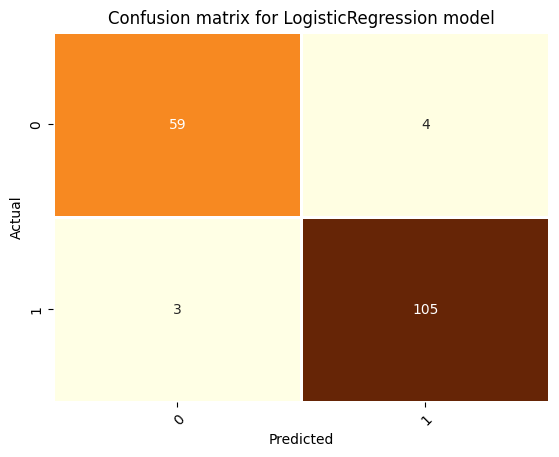

The model's performance on test data: 
Accuracy: 0.9591 
Precision: 0.9633 
Recall: 0.9722 
f1-score: 0.9677


In [13]:
# Let's evaluate our model on the test data
accuracy, precision, recall, f1score = my_dataset.model_clf_evaluate(
    average="binary", plot_confusion=True, normalize_conmat=False
)
print(
    "The model's performance on test data:",
    f"\nAccuracy: {accuracy:.4f}",
    f"\nPrecision: {precision:.4f}",
    f"\nRecall: {recall:.4f}",
    f"\nf1-score: {f1score:.4f}",
)

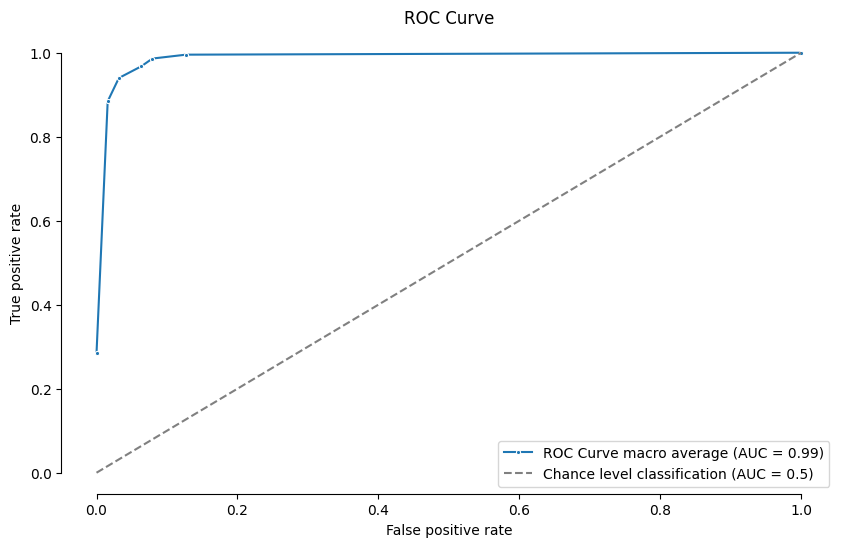

In [14]:
# Let's plot the ROC and precision recall curve
y_test_proba = pipeline.predict_proba(my_dataset.X_test)
# ROC
_plotting_ax, best_threshold = psml.plot_ROC_binary(
    y_test=my_dataset.y_test, y_pred_proba=y_test_proba[:, 1], average="macro"
)


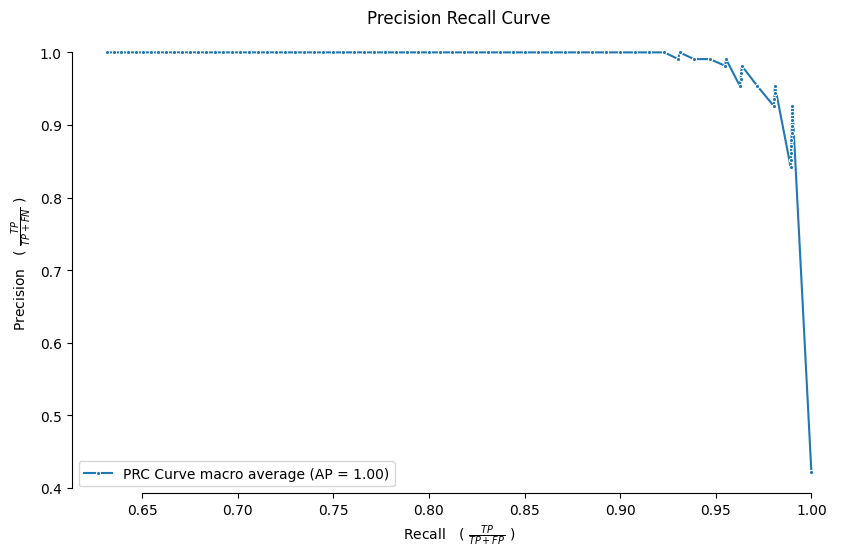

In [15]:
# PRC
_plotting_ax, best_threshold = psml.plot_PRC_binary(
    y_test=my_dataset.y_test, y_pred_proba=y_test_proba[:, 1], average="macro"
)